Used Spectral Clustering here. The affinity matrix is calculated and fed to the pre-built spectral clustering function.

The values of the matrix are:
affinity = np.exp(-(a*wires + b*dist) / mean_product)
where 'a' and 'b' are weights that can be used to encourage a specific optimization.

Sources:
* [Spectral Clustering example](https://mashaan14.github.io/YouTube-channel/spectral_clustering/2024_01_15_spectral_clustering)
* [MIT Lecture](https://www.youtube.com/watch?v=cxTmmasBiC8)




In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import math
import random

In [8]:
#Graph Gen 1.2
# Added inputs and outputs
# The power consumption for a node ranges from 1 to 50 units and uniformly distributed.
# Plus the area may vary from 1 to 5 units as well, uniformly distributed
# Ensured the following:
# The input nodes must have at least one outgoing edge and no incoming edge
# The output nodes must have one incoming edge only
# Internal nodes must have at least one incoming and at least one outgoing edge

def generate_netlist(
    num_nodes=50,
    num_edges=100,
    enable_area=True,
    #Area (chip constraints) of the node or the gate assembly
    enable_power=True,
    # Power consumption of the gate (used to optimize or reduce heat generation or power consumption per chip)
    enable_wire_count=True,
    # Number of wires represented by an edge
    enable_distance=True,
    # Distance of the wire to calculate power dissipation and delay
    seed = 42
):
    """Generates a netlist as a graph with configurable node & edge attributes."""

    #Generate a directed graph
    G = nx.DiGraph()

    # Estimate number of inputs and outputs
    # Assuming num_inputs and num_outputs to be the functions below
    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]
    internal_nodes = [f"N_{i}" for i in range(num_nodes)]

    # Create internal nodes with attributes
    # Area carying from A to 5A
    # Power Consumption varying from P to 50P
    for node in internal_nodes:
        G.add_node(node)
        if enable_area:
            G.nodes[node]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node]['power'] = round(random.uniform(1.0, 50.0), 2)

    # Create input and output nodes
    for node in input_nodes + output_nodes:
        G.add_node(node)

    # Ensure input nodes have at least one outgoing edge
    for input_node in input_nodes:
        target = random.choice(internal_nodes)
        G.add_edge(input_node, target)

    # Ensure output nodes have exactly one incoming edge
    for output_node in output_nodes:
        source = random.choice(internal_nodes)
        G.add_edge(source, output_node)

    # Ensure internal nodes have at least one incoming and one outgoing edge
    # i.e. no gate is useless in the circuit
    for node in internal_nodes:
        if G.in_degree(node) == 0:
            source = random.choice(input_nodes + internal_nodes)
            G.add_edge(source, node)
        if G.out_degree(node) == 0:
            target = random.choice(internal_nodes + output_nodes)
            G.add_edge(node, target)

    # Add additional edges up to num_edges while preventing duplicate edges and self-loops
    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(internal_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))

    # Assign edge attributes
    for u, v in G.edges():
        if enable_wire_count:
            G.edges[u, v]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes

In [9]:
# Borrowed from Kmeans_1d.ipynb
def compute_wire_metrics(G, cluster_labels, input_nodes, output_node):
    """Computes the number of cuts and total wire length."""
    # Number of intercluster wires
    num_cuts = 0
    # Total wirelength, both intra and inter cluster
    total_wire_length = 0

    # Convert G to a directed graph for longest path calculation
    G_weighted = nx.DiGraph()

    for u, v in G.edges():
        wire_length = G.edges[u, v].get("distance", 1)
        cluster_u, cluster_v = cluster_labels.get(u), cluster_labels.get(v)

        if cluster_u == cluster_v:
            edge_weight = wire_length  # Intracluster
        else:
            edge_weight = wire_length * 10  # Intercluster
            num_cuts += 1
            # Note intercluster distances get multiplied by 10

        total_wire_length += edge_weight
        G_weighted.add_edge(u, v, weight=edge_weight)  # Construct weighted graph

    # Remove cycles if any
    while not nx.is_directed_acyclic_graph(G_weighted):
        try:
            cycle = next(nx.simple_cycles(G_weighted))  # Find a cycle
            min_edge = min(
                ((cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))),
                key=lambda e: G_weighted.edges[e].get("weight", 1)
            )
            G_weighted.remove_edge(*min_edge)  # Remove lowest-weight edge
        except StopIteration:
            break

    # Find the critical length (longest path from any input node to output)
    critical_length = 0
    for input_node in input_nodes:
        if input_node in G_weighted.nodes:
            for output_node in output_node:  # Iterate over all output nodes
                if output_node in G_weighted.nodes:
                    try:
                      path = nx.dag_longest_path(G_weighted, weight="weight")
                      path_length = sum(G_weighted[u][v]["weight"] for u, v in zip(path, path[1:]))
                      critical_length = max(critical_length, path_length)
                    except nx.NetworkXNoPath:
                        pass  # No valid path exists for this input-output pair

    print(f"Final: Cuts = {num_cuts}, Total Wire Length = {total_wire_length}, Critical Length = {critical_length}")
    return num_cuts, total_wire_length, critical_length


# Generic function to visualize clusters
def visualize_clusters(graph, cluster_labels):
    pos = nx.spring_layout(graph, seed=42)
    clusters = set(cluster_labels.values())
    colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))

    for i, cluster in enumerate(clusters):
        nodes = [node for node in graph.nodes if cluster_labels[node] == cluster]
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=[colors[i]], label=f'Cluster {cluster}')

    nx.draw_networkx_edges(graph, pos, alpha=0.4)
    nx.draw_networkx_labels(graph, pos, font_size=8)
    plt.title("Spectral Clustering of VLSI Netlist")
    plt.axis('off')
    plt.legend()
    plt.show()

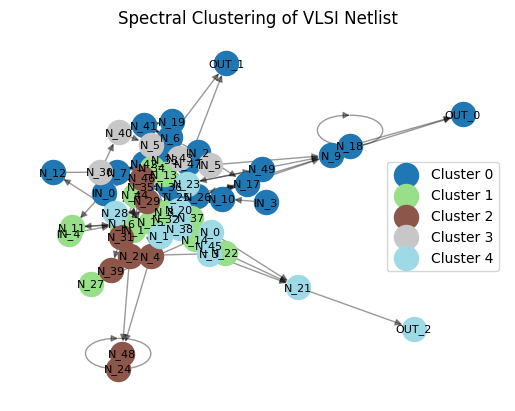

Final: Cuts = 43, Total Wire Length = 2784.650000000001, Critical Length = 634.42
Spectral Clustering Metrics for k=5:
  - Intercluster Cuts: 43
  - Total Wire Length: 2784.65
  - Critical Path Length (Delay): 634.42


In [10]:
# Spectral clustering function that takes in graph and number of cluster k
# Returns a node to cluster label mapping
def spectral_clustering_partition(graph, k):
    # Mapping nodes to matrix indices for adjacency matrix construction
    nodes = list(graph.nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)

    # Initialize the affinity matrix
    A = np.zeros((n, n))
    # These can be though of as parameters to compute the distance metric
    # alpha is the wieght for #wires and beta is the weight for distance of wire
    alpha = 1.0
    beta = 1.0

    # Compute normalization term
    sum_vals = []
    for u, v in graph.edges:
        wires = graph[u][v].get('wires', 1)
        dist = graph[u][v].get('distance', 1.0)
        sum_vals.append(alpha*wires + beta*dist)
    mean_sum = np.mean(sum_vals) if sum_vals else 1.0

    # Build affinity matrix
    # A[i][j] = A[j][i] = exp(-(a*wires + b*dist) / mean_sum)
    for u, v in graph.edges:
        i, j = node_index[u], node_index[v]
        wires = graph[u][v].get('wires', 1)
        dist = graph[u][v].get('distance', 1.0)
        affinity = np.exp(-(wires * dist) / mean_sum)
        A[i][j] = A[j][i] = affinity

    # Used spectral clustering function
    clustering = SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels='kmeans', random_state=42)
    labels = clustering.fit_predict(A)

    return {node: labels[i] for node, i in node_index.items()}


# Example usage
if __name__ == "__main__":
    graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=120, seed=42)
    k = 5  # Number of clusters

    cluster_labels = spectral_clustering_partition(graph, k)
    visualize_clusters(graph, cluster_labels)

    num_cuts, total_wire_length, critical_length = compute_wire_metrics(graph,cluster_labels, inputs, outputs)
    print(f"Spectral Clustering Metrics for k={k}:")
    print(f"  - Intercluster Cuts: {num_cuts}")
    print(f"  - Total Wire Length: {total_wire_length:.2f}")
    print(f"  - Critical Path Length (Delay): {critical_length:.2f}")
